In [1]:
import os
import glob
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.stats import mode
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

import torch
from torch.multiprocessing import Pool, set_start_method
from concurrent.futures import ThreadPoolExecutor
import joblib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [2]:
# Set environment variable to suppress warning
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
image_dir = r"C:\Users\WilsonSIRL5-MCY-E113\Documents\White glacier ML\tif in total"
image_files = glob.glob(os.path.join(image_dir, "*.tif"))

In [4]:
# Parallel image reading and processing using ThreadPoolExecutor
def process_image(img_path):
    # Read the image using Rasterio
    with rasterio.open(img_path) as img:
        # Load image data onto GPU using PyTorch tensors with half precision to reduce memory usage
        r = torch.tensor(img.read(1), dtype=torch.float16).to(device)
        g = torch.tensor(img.read(2), dtype=torch.float16).to(device)
        b = torch.tensor(img.read(3), dtype=torch.float16).to(device)
        ir = torch.tensor(img.read(4), dtype=torch.float16).to(device)  

    # Stack bands and reshape
    stacked = torch.stack((r, g, b, ir), dim=-1).view(-1, 4)
    return stacked

# Process images in parallel using ThreadPoolExecutor
all_data = []
with ThreadPoolExecutor() as executor:
    results = executor.map(process_image, image_files)
    all_data.extend(results)

# Combine all data from all images
all_data = torch.cat(all_data, dim=0)

In [5]:
from sklearn.preprocessing import StandardScaler

# Assume all_data_np is a 2D array of shape (num_pixels, 4) for RGB + IRED bands
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(all_data)

# K-means Clustering (Unsupervised Step)

In [6]:
# Apply PCA for dimensionality reduction before clustering
# Convert data to numpy for PCA and clustering
all_data_np = all_data.cpu().numpy()  # Move data to CPU for PCA and clustering

# Apply PCA to reduce dimensionality to 2 components for faster clustering
pca = PCA(n_components=2)
all_data_pca = pca.fit_transform(all_data_np)

# Get the explained variance ratio for the 2 components
explained_variance_ratio = pca.explained_variance_ratio_

# Print the variance explained by each component
print(f"Variance explained by PC1: {explained_variance_ratio[0]*100:.2f}%")
print(f"Variance explained by PC2: {explained_variance_ratio[1]*100:.2f}%")

# Print total variance explained by both components
print(f"Total explained variance with 2 components: {explained_variance_ratio.sum()*100:.2f}%")

Variance explained by PC1: 99.65%
Variance explained by PC2: 0.31%
Total explained variance with 2 components: 99.96%


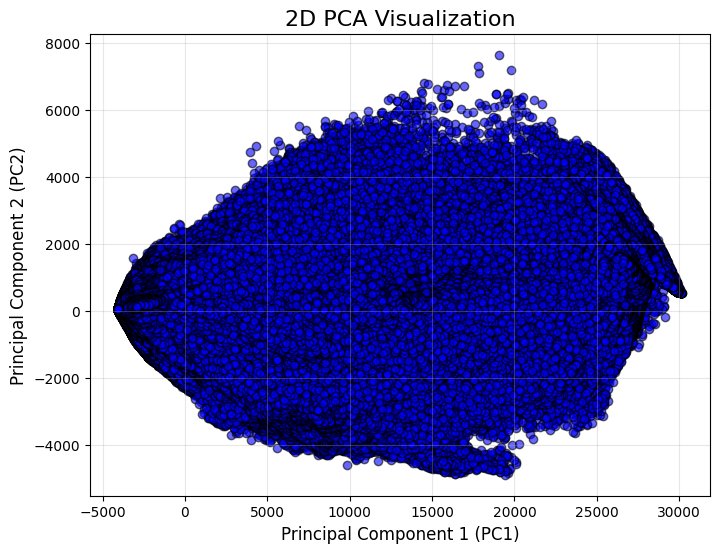

In [10]:
# Plotting the PCA-transformed data
plt.figure(figsize=(8, 6))
plt.scatter(all_data_pca[:, 0], all_data_pca[:, 1], c='blue', alpha=0.6, edgecolor='k')
plt.title("2D PCA Visualization", fontsize=16)
plt.xlabel("Principal Component 1 (PC1)", fontsize=12)
plt.ylabel("Principal Component 2 (PC2)", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
import hdbscan

# Apply HDBSCAN clustering
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, n_jobs=4)
labels = hdbscan_clusterer.fit_predict(all_data_pca)

In [ ]:
# Print label counts
unique, counts = np.unique(labels, return_counts=True)
print(f"Label counts: {dict(zip(unique, counts))}")

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

cluster_prob = hdbscan_clusterer.probabilities_
print("Probability array shape:", cluster_prob.shape)

In [10]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan_clusterer = DBSCAN(eps=0.5, min_samples=4)
labels = dbscan_clusterer.fit_predict(all_data_pca)

# Print label counts
unique, counts = np.unique(labels, return_counts=True)
print(f"Label counts: {dict(zip(unique, counts))}")

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

MemoryError: 

In [7]:
# Apply PCA for dimensionality reduction before clustering
# Convert data to numpy for PCA and clustering
all_data_np = all_data.cpu().numpy()  # Move data to CPU for PCA and clustering

# Apply PCA to reduce dimensionality to 2 components for faster clustering
pca = PCA(n_components=2)
all_data_pca = pca.fit_transform(all_data_np)

# Apply KMeans clustering with 4 clusters to get pseudo labels for ice, snow1 amd snow2, and ground
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(all_data_pca)

# Print label counts
unique, counts = np.unique(labels, return_counts=True)
print(f"Label counts: {dict(zip(unique, counts))}")

Label counts: {0: 390127924, 1: 52892331, 2: 44652149, 3: 62910846}


In [39]:
from sklearn.utils import resample

# Create a balanced sample of the dataset (Stratified Sampling)
sample_size_per_label = 100000  # Customize based on your need
resampled_data = []
resampled_labels = []

for label in np.unique(labels):
    label_data = all_data_pca[labels == label]
    resampled_data.append(resample(label_data, n_samples=sample_size_per_label, random_state=42))
    resampled_labels.extend([label] * sample_size_per_label)

all_data_sample = np.vstack(resampled_data)
labels_sample = np.array(resampled_labels)

# Print label counts
unique, counts = np.unique(labels_sample, return_counts=True)
print(f"Label counts: {dict(zip(unique, counts))}")

Label counts: {0: 100000, 1: 100000, 2: 100000, 3: 100000}


In [16]:
# Subsample equally from each cluster (Cluster Subsampling)
sample_size = 100000  # Customize based on your requirement
sampled_indices = []
for label in np.unique(labels):
    label_indices = np.where(labels == label)[0]
    sampled_indices.extend(np.random.choice(label_indices, sample_size, replace=False))

all_data_sample = all_data_pca[sampled_indices]
labels_sample = labels[sampled_indices]

# Print label counts
unique, counts = np.unique(labels_sample, return_counts=True)
print(f"Label counts: {dict(zip(unique, counts))}")

Label counts: {0: 100000, 1: 100000, 2: 100000, 3: 100000}


In [8]:
# Calculate silhouette score for quality assessment using a random sample of 100,000 data points (Random Resampling)
sample_size = 10000 # Fixed sample size
sample_indices = np.random.choice(all_data_pca.shape[0], size=sample_size, replace=False)
all_data_sample = all_data_pca[sample_indices]
labels_sample = labels[sample_indices]
# Print label counts
unique, counts = np.unique(labels_sample, return_counts=True)
print(f"Label counts: {dict(zip(unique, counts))}")

Label counts: {0: 7042, 1: 971, 2: 809, 3: 1178}


In [9]:
# Parallelize silhouette score calculation
def calculate_silhouette_score(data, labels):
    return silhouette_score(data, labels)

with ThreadPoolExecutor() as executor:
    future = executor.submit(calculate_silhouette_score, all_data_sample, labels_sample)
    silhouette_avg = future.result()

print(f"Silhouette Score (sampled data): {silhouette_avg}")

# Print label counts
unique, counts = np.unique(labels_sample, return_counts=True)
print(f"Label counts: {dict(zip(unique, counts))}")

Silhouette Score (sampled data): 0.8346136747491318
Label counts: {0: 7042, 1: 971, 2: 809, 3: 1178}


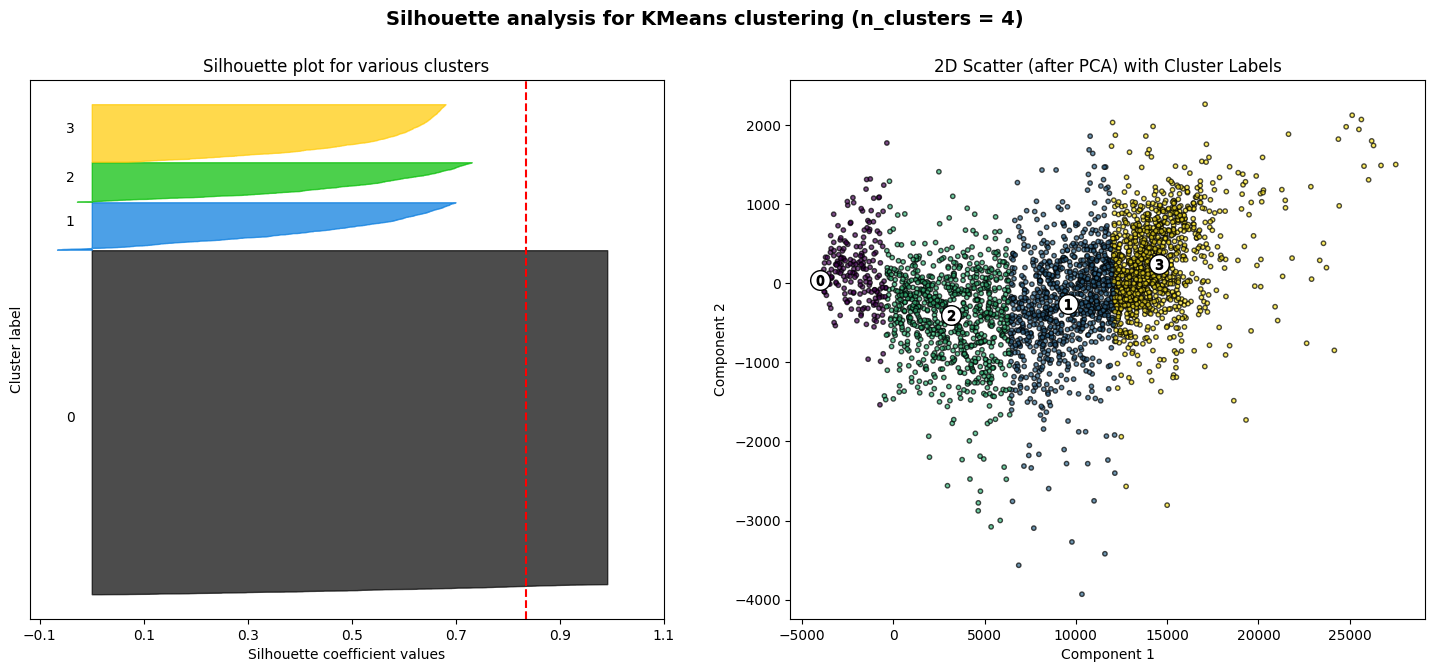

In [16]:
# Visualize silhouette score for the sampled data
sample_silhouette_values = silhouette_samples(all_data_sample, labels_sample)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle("Silhouette analysis for KMeans clustering (n_clusters = 4)", 
             fontsize=14, fontweight='bold')

# Silhouette subplot
ax1.set_title("Silhouette plot for various clusters")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[labels_sample == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0,
                      ith_cluster_silhouette_values,
                      facecolor=color,
                      edgecolor=color,
                      alpha=0.7)
    # Label the silhouette plots with their cluster numbers in the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # gap

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

# ------------------------------------------------------
# 5. Plot the 2D embedding of the data (PCA or t-SNE)
# ------------------------------------------------------
ax2.set_title("2D Scatter (after PCA) with Cluster Labels")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")

# Use the cluster labels as color
scatter = ax2.scatter(all_data_sample[:, 0], all_data_sample[:, 1],
                      c=labels_sample, 
                      cmap='viridis',
                      alpha=0.7, 
                      s=10,     # marker size
                      edgecolor='k')

# Plot the cluster centers in the same 2D space
centers_pca = kmeans.cluster_centers_[:, :2]  
ax2.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            marker='o', c='white', alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers_pca):
    ax2.scatter(c[0], c[1], 
                marker='$%d$' % i, 
                alpha=1, s=50, edgecolor='k')

plt.show()

In [13]:
from scipy.spatial import ConvexHull

def plot_convex_hull(points, ax, color):
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], color=color)



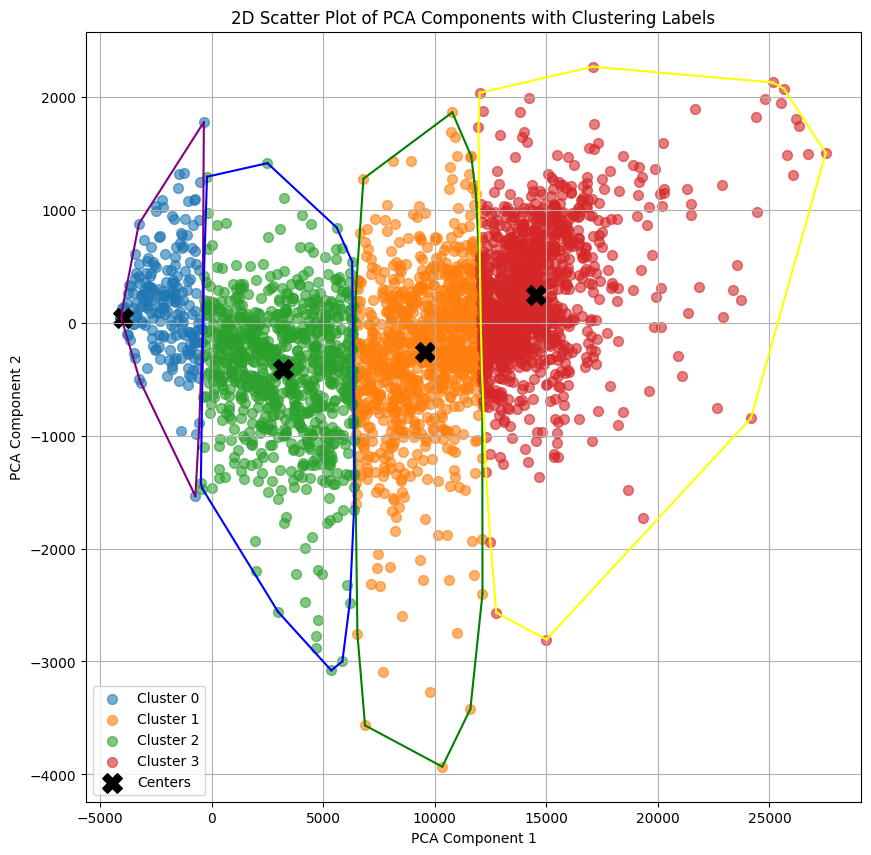

In [23]:
# Plot the data and clusters
plt.figure(figsize=(10, 10))
colors = ['purple', 'green', 'blue', 'yellow']

# Loop through clusters
for cluster_id in range(4):  # Number of clusters
    cluster_points = all_data_sample[labels_sample == cluster_id]  # Points in this cluster
    
    # Plot the points
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                label=f"Cluster {cluster_id}", alpha=0.6, s=50)
    
    # Compute and plot Convex Hull
    if len(cluster_points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], colors[cluster_id])

# Add cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X', label='Centers')

# Formatting
plt.title("2D Scatter Plot of PCA Components with Clustering Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

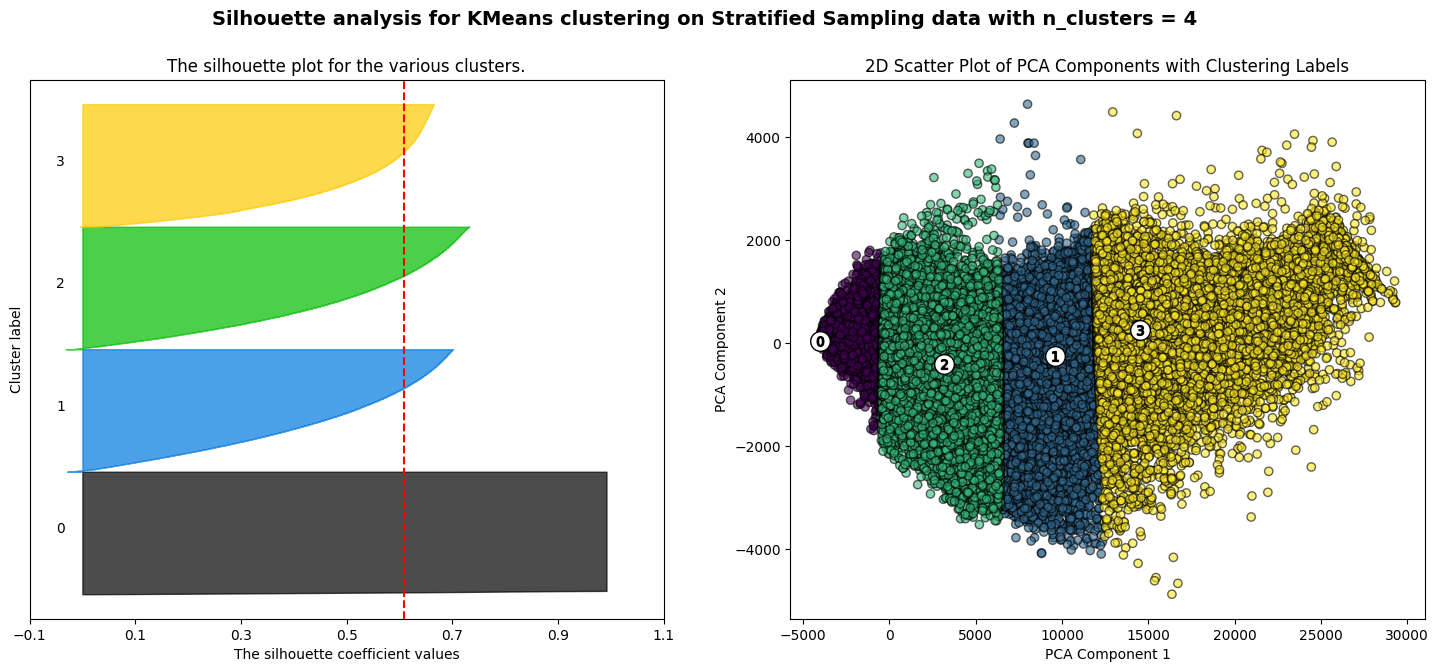

In [41]:
# Visualize silhouette score for the sampled data
sample_silhouette_values = silhouette_samples(all_data_sample, labels_sample)

# Visualize silhouette score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle("Silhouette analysis for KMeans clustering on Stratified Sampling data with n_clusters = 4", fontsize=14, fontweight='bold')

# Silhouette plot
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

y_lower = 10
for i in range(4):
    ith_cluster_silhouette_values = sample_silhouette_values[labels_sample == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples gap between clusters

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

# Scatter plot of clustered data
ax2.set_title("2D Scatter Plot of PCA Components with Clustering Labels")
ax2.set_xlabel("PCA Component 1")
ax2.set_ylabel("PCA Component 2")

colors = plt.cm.nipy_spectral(labels_sample.astype(float) / 4)
ax2.scatter(all_data_sample[:, 0], all_data_sample[:, 1], c=labels_sample, cmap='viridis', alpha=0.6, marker='o', edgecolor='k')

# Labeling the clusters
centers = kmeans.cluster_centers_
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.show()

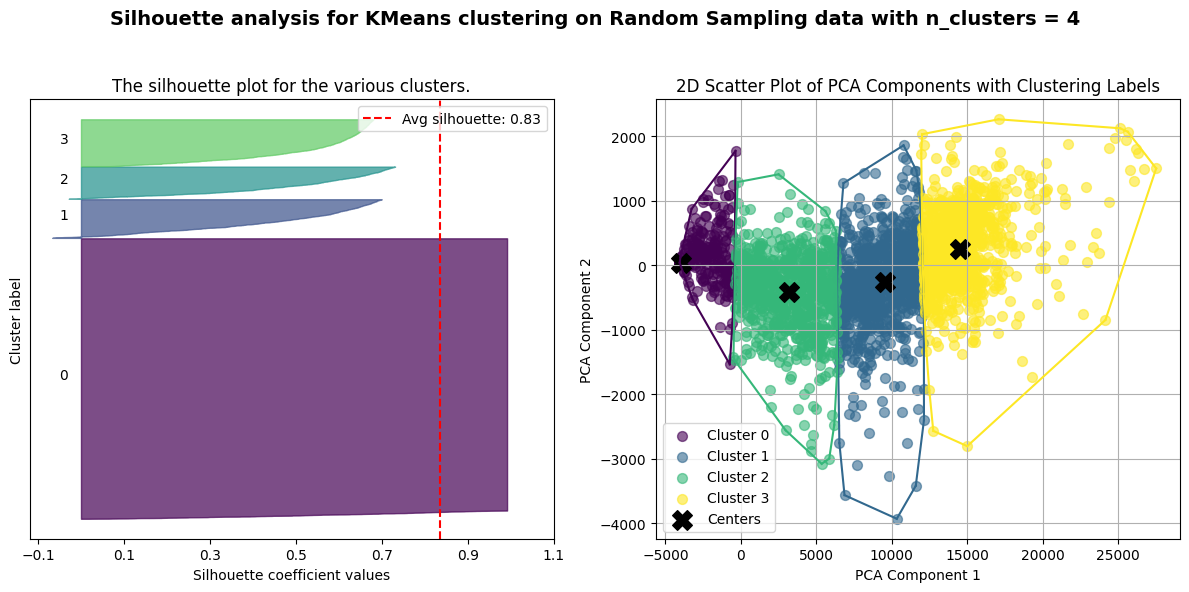

In [28]:
from sklearn.metrics import silhouette_samples
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import viridis

# Calculate silhouette values for sampled data
sample_silhouette_values = silhouette_samples(all_data_sample, labels_sample)
n_clusters = 4  # Define the number of clusters

# Function to plot silhouette analysis
def plot_silhouette_analysis(ax, silhouette_values, labels, n_clusters):
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    y_lower = 10  # Initial position for plotting
    for cluster_id in range(n_clusters):
        # Extract silhouette scores for the current cluster
        cluster_silhouette_values = silhouette_values[labels == cluster_id]
        cluster_silhouette_values.sort()

        size_cluster = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster

        # Generate color for this cluster using viridis
        color = viridis(float(cluster_id) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, cluster_silhouette_values,
            facecolor=color, edgecolor=color, alpha=0.7
        )
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster_id))
        y_lower = y_upper + 10  # Add space between clusters

    # Draw vertical line for average silhouette score
    silhouette_avg = np.mean(silhouette_values)
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Avg silhouette: {silhouette_avg:.2f}")
    ax.set_yticks([])
    ax.set_xticks(np.arange(-0.1, 1.1, 0.2))
    ax.legend(loc='upper right')

# Function to plot 2D data with clustering results
def plot_clusters_with_convex_hull(data, labels, centers, n_clusters, ax):
    colors = viridis(np.linspace(0, 1, n_clusters))  # Use viridis colormap

    for cluster_id in range(n_clusters):
        cluster_points = data[labels == cluster_id]

        # Plot data points
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   label=f"Cluster {cluster_id}", alpha=0.6, s=50, color=colors[cluster_id])

        # Plot Convex Hull
        if len(cluster_points) >= 3:  # ConvexHull requires at least 3 points
            hull = ConvexHull(cluster_points)
            for simplex in hull.simplices:
                ax.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 
                        color=colors[cluster_id], linewidth=1.5)

    # Plot cluster centers
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X', label='Centers')
    ax.set_title("2D Scatter Plot of PCA Components with Clustering Labels")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.legend(loc='lower left')
    ax.grid(True)

# Set up subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Silhouette analysis for KMeans clustering on Random Sampling data with n_clusters = 4", fontsize=14, fontweight='bold')

# Plot silhouette analysis
plot_silhouette_analysis(ax1, sample_silhouette_values, labels_sample, n_clusters)

# Plot clustering results
plot_clusters_with_convex_hull(all_data_sample, labels_sample, kmeans.cluster_centers_, n_clusters, ax2)

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()


# Machine Learning Classification Model

In [44]:
# Train a Random Forest classifier with optimizations for faster computation
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_data_sample, labels_sample, test_size=0.2, random_state=42)

# Use a smaller number of estimators and limit the max depth to speed up training
rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = rf_classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.99975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20006
           1       1.00      1.00      1.00     20045
           2       1.00      1.00      1.00     19908
           3       1.00      1.00      1.00     20041

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000



Random Forest Classifier Accuracy: 99.98%
Cross-validation scores: [0.99976562 0.99975    0.99965625 0.9996875  0.99971875]
Mean cross-validation score: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20006
           1       1.00      1.00      1.00     20045
           2       1.00      1.00      1.00     19908
           3       1.00      1.00      1.00     20041

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000



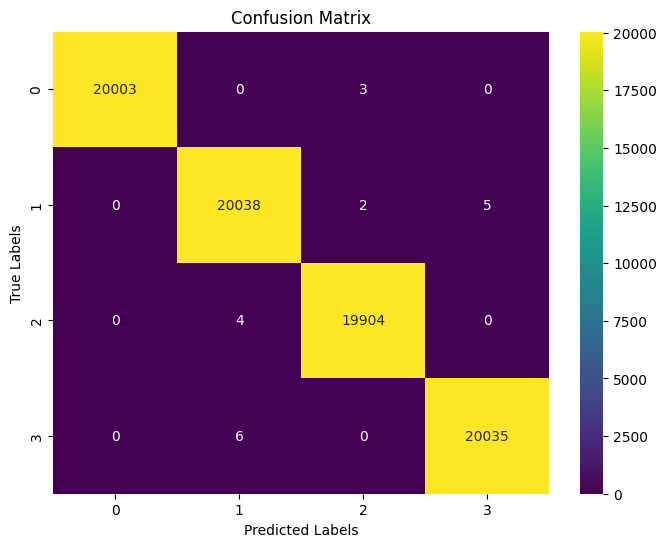

In [45]:
# Evaluate the model
accuracy = rf_classifier.score(X_test, y_test)
print(f"Random Forest Classifier Accuracy: {accuracy * 100:.2f}%")

cross_val_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, n_jobs=-1)
print(f'Cross-validation scores: {cross_val_scores}')
print(f'Mean cross-validation score: {cross_val_scores.mean():.2f}')

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [46]:
# Save the trained model for future use
model_path = "rf_classifier_model31DEC.pkl"
joblib.dump(rf_classifier, model_path)
print(f"Model saved to {model_path}")

Model saved to rf_classifier_model31DEC.pkl


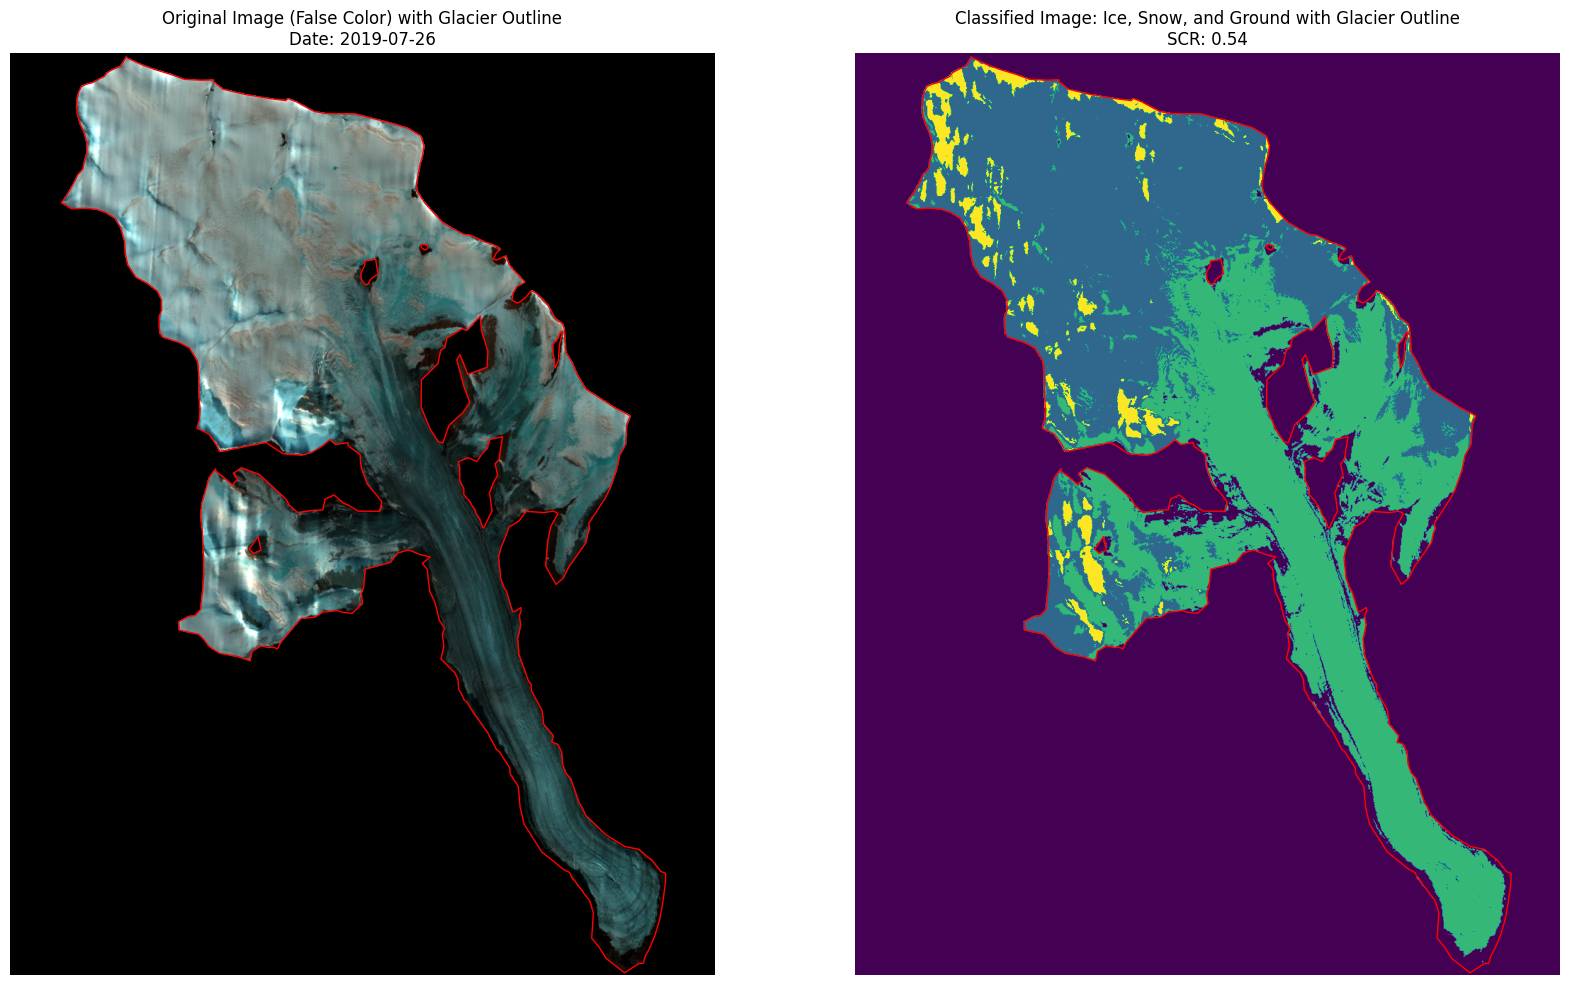

In [ ]:
# Classify a new image using the trained Random Forest model
def classify_image(image_path, model, pca_transformer):
    # Read the new image using Rasterio
    with rasterio.open(image_path) as img:
        r = img.read(1)
        g = img.read(2)
        b = img.read(3)
        ir = img.read(4)
        

    # Stack bands into a single array
    stacked = np.dstack((r, g, b, ir)).reshape((-1, 4))

    # Apply PCA transformation
    stacked_pca = pca_transformer.transform(stacked)

    # Predict labels for the new image
    predicted_labels = model.predict(stacked_pca)
    
    # Reshape to original image shape
    label_img = predicted_labels.reshape(img.height, img.width)
    
    return label_img

# Example usage
image_dir = r"C:\Users\WilsonSIRL5-MCY-E113\Documents\White glacier ML\tif in total"
image_file = "Sentinel2_2019-07-26(2).tif"

classified_image = classify_image(os.path.join(image_dir, image_file), rf_classifier, pca)

# Calculate areal extent
unique, counts = np.unique(classified_image, return_counts=True)
pixel_counts = dict(zip(unique, counts))

ice_area = pixel_counts.get(2, 0)  # Assuming 2 is ice
snow_area = (pixel_counts.get(1, 0)) + (pixel_counts.get(3, 0))  # Assuming 1 + 3 is snow

total_area = ice_area + snow_area

# Calculate Snow Cover Ratio (SCR)
scr = snow_area / total_area if total_area != 0 else 0

# Visualize the classified image
# Define the image directory at the beginning of the code

# Use the image directory in the code
with rasterio.open(os.path.join(image_dir, image_file)) as src:
    band_1 = src.read(1)  # Blue
    band_2 = src.read(2)  # Green
    band_3 = src.read(3)  # Red
    band_4 = src.read(4)  # NIR
    sentinel_crs = src.crs
    sentinel_extent = src.bounds
# Stack the bands to create an RGB image
false_color = np.dstack((band_4, band_2, band_1))

# Normalize to enhance visualization (0-255 scale)
false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min()) * 255
false_color = false_color.astype(np.uint8)

# Increase contrast to better show snow and ice
contrast_factor = 1.5
mean = np.mean(false_color, axis=(0, 1), keepdims=True)
false_color = np.clip((false_color - mean) * contrast_factor + mean, 0, 255).astype(np.uint8)

# Load the glacier outline shapefile and reproject to match the Sentinel-2 image CRS
glacier_outline = gpd.read_file(r"C:\Users\WilsonSIRL5-MCY-E113\Documents\White glacier ML\White outline\glims_polygons.shp")
glacier_outline = glacier_outline.to_crs(sentinel_crs)

# Display side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Set the extent to match the Sentinel-2 image bounds
extent = [sentinel_extent.left, sentinel_extent.right, sentinel_extent.bottom, sentinel_extent.top]

# Original image with glacier outline (False Color for better ice and snow distinction)
axes[0].imshow(false_color, extent=extent)
glacier_outline.plot(ax=axes[0], facecolor='none', edgecolor='r', zorder=2)
axes[0].set_title(f'Original Image (False Color) with Glacier Outline\nDate: {image_file.split("_")[1].split(".")[0].split("(")[0]}')
axes[0].axis('off')

# Classified image with glacier outline
axes[1].imshow(classified_image, cmap='viridis', extent=extent)
glacier_outline.plot(ax=axes[1], facecolor='none', edgecolor='r', zorder=2)
axes[1].set_title(f'Classified Image: Ice, Snow, and Ground with Glacier Outline\nSCR: {scr:.2f}')
axes[1].axis('off')

plt.show()


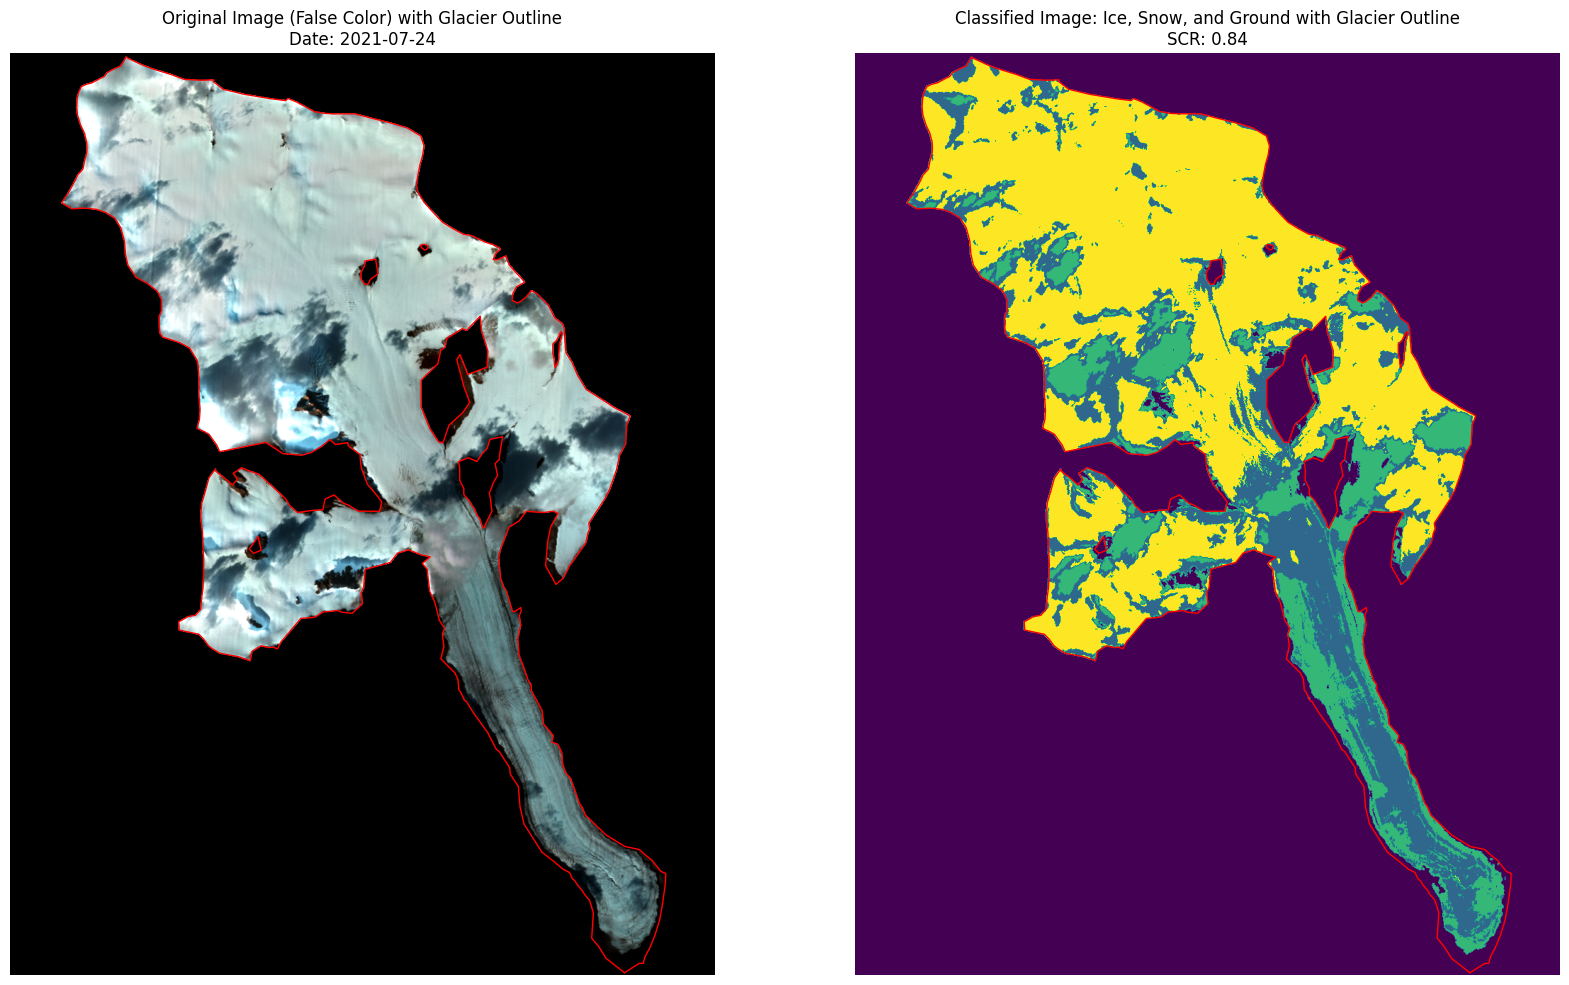

In [38]:
# Classify a new image using the trained Random Forest model
def classify_image(image_path, model, pca_transformer):
    # Read the new image using Rasterio
    with rasterio.open(image_path) as img:
        r = img.read(1)
        g = img.read(2)
        b = img.read(3)
        ir = img.read(4)
        

    # Stack bands into a single array
    stacked = np.dstack((r, g, b, ir)).reshape((-1, 4))

    # Apply PCA transformation
    stacked_pca = pca_transformer.transform(stacked)

    # Predict labels for the new image
    predicted_labels = model.predict(stacked_pca)
    
    # Reshape to original image shape
    label_img = predicted_labels.reshape(img.height, img.width)
    
    return label_img

# Example usage
image_dir = r"C:\Users\WilsonSIRL5-MCY-E113\Documents\White glacier ML\tif in total"
image_file = "Sentinel2_2021-07-24.tif"

classified_image = classify_image(os.path.join(image_dir, image_file), rf_classifier, pca)
# Calculate areal extent
unique, counts = np.unique(classified_image, return_counts=True)
pixel_counts = dict(zip(unique, counts))

ice_area = pixel_counts.get(2, 0)  # Assuming 2 is ice
snow_area = (pixel_counts.get(1, 0)) + (pixel_counts.get(3, 0))  # Assuming 1 + 3 is snow

total_area = ice_area + snow_area

# Calculate Snow Cover Ratio (SCR)
scr = snow_area / total_area if total_area != 0 else 0

# Visualize the classified image
# Define the image directory at the beginning of the code

# Use the image directory in the code
with rasterio.open(os.path.join(image_dir, image_file)) as src:
    band_1 = src.read(1)  # Blue
    band_2 = src.read(2)  # Green
    band_3 = src.read(3)  # Red
    band_4 = src.read(4)  # NIR
    sentinel_crs = src.crs
    sentinel_extent = src.bounds
# Stack the bands to create an RGB image
false_color = np.dstack((band_4, band_2, band_1))

# Normalize to enhance visualization (0-255 scale)
false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min()) * 255
false_color = false_color.astype(np.uint8)

# Increase contrast to better show snow and ice
contrast_factor = 1.5
mean = np.mean(false_color, axis=(0, 1), keepdims=True)
false_color = np.clip((false_color - mean) * contrast_factor + mean, 0, 255).astype(np.uint8)

# Load the glacier outline shapefile and reproject to match the Sentinel-2 image CRS
glacier_outline = gpd.read_file(r"C:\Users\WilsonSIRL5-MCY-E113\Documents\White glacier ML\White outline\glims_polygons.shp")
glacier_outline = glacier_outline.to_crs(sentinel_crs)

# Display side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Set the extent to match the Sentinel-2 image bounds
extent = [sentinel_extent.left, sentinel_extent.right, sentinel_extent.bottom, sentinel_extent.top]

# Original image with glacier outline (False Color for better ice and snow distinction)
axes[0].imshow(false_color, extent=extent)
glacier_outline.plot(ax=axes[0], facecolor='none', edgecolor='r', zorder=2)
axes[0].set_title(f'Original Image (False Color) with Glacier Outline\nDate: {image_file.split("_")[1].split(".")[0].split("(")[0]}')
axes[0].axis('off')

# Classified image with glacier outline
axes[1].imshow(classified_image, cmap='viridis', extent=extent)
glacier_outline.plot(ax=axes[1], facecolor='none', edgecolor='r', zorder=2)
axes[1].set_title(f'Classified Image: Ice, Snow, and Ground with Glacier Outline\nSCR: {scr:.2f}')
axes[1].axis('off')

plt.show()


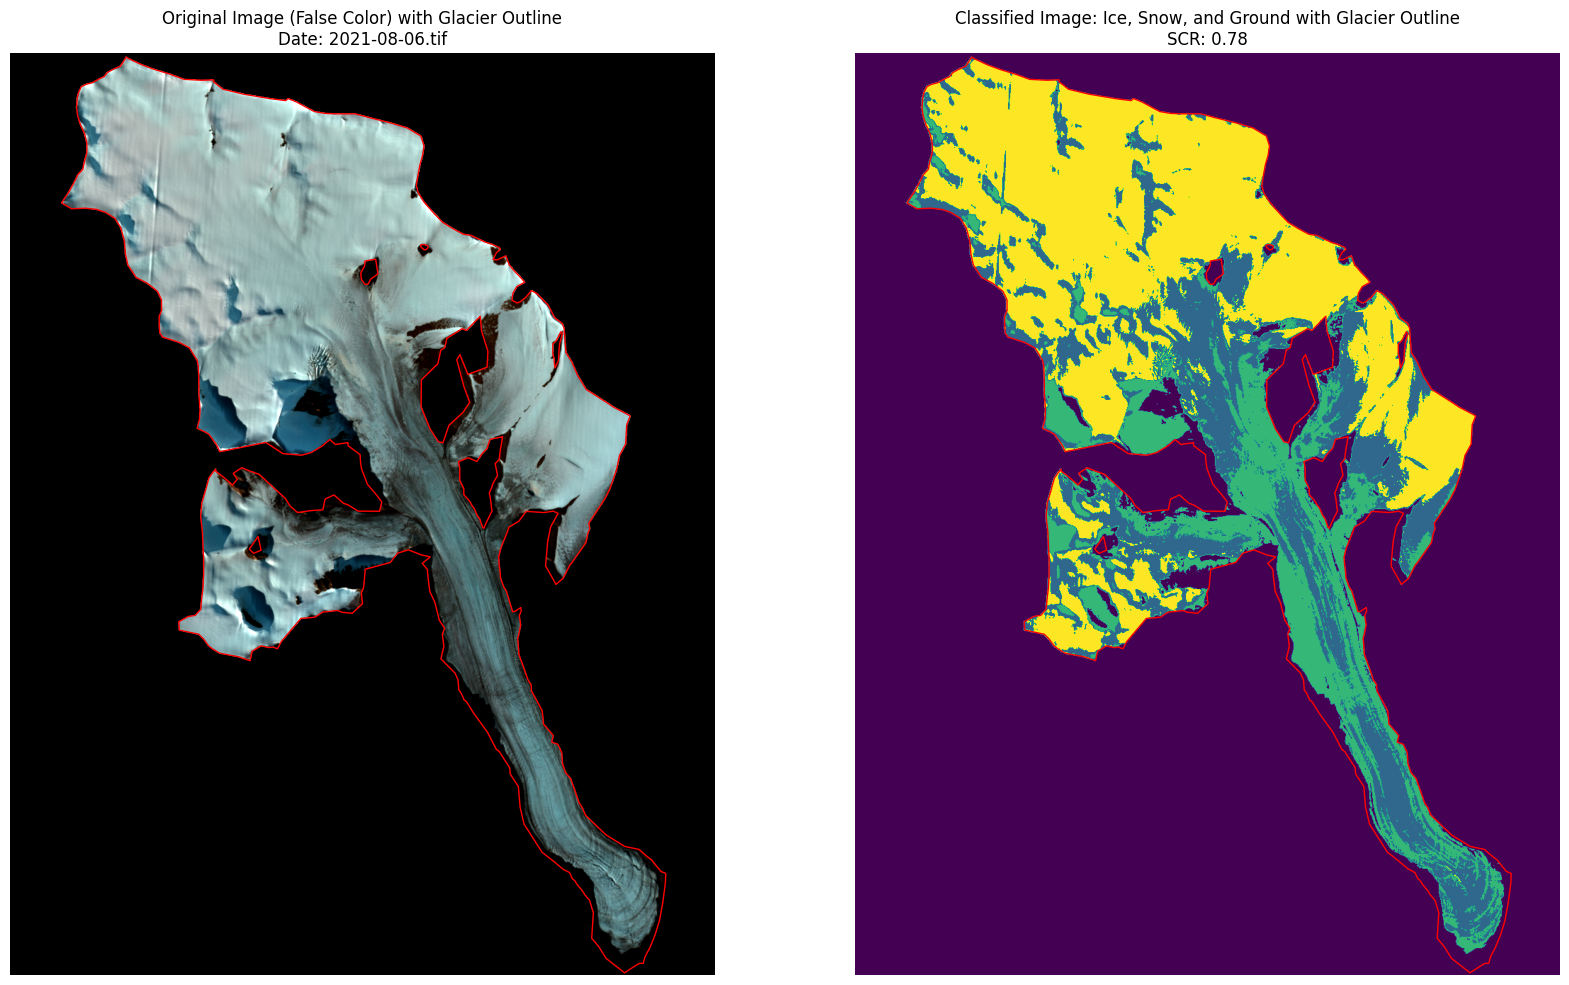

In [37]:
# Classify a new image using the trained Random Forest model
def classify_image(image_path, model, pca_transformer):
    # Read the new image using Rasterio
    with rasterio.open(image_path) as img:
        r = img.read(1)
        g = img.read(2)
        b = img.read(3)
        ir = img.read(4)
        
    # Stack bands into a single array
    stacked = np.dstack((r, g, b, ir)).reshape((-1, 4))

    # Apply PCA transformation
    stacked_pca = pca_transformer.transform(stacked)

    # Predict labels for the new image
    predicted_labels = model.predict(stacked_pca)
    
    # Reshape to original image shape
    label_img = predicted_labels.reshape(img.height, img.width)
    
    return label_img

# Example usage
image_dir = r"C:\Users\WilsonSIRL5-MCY-E113\Documents\White glacier ML\tif in total"
image_file = "Sentinel2_2021-08-06.tif"

classified_image = classify_image(os.path.join(image_dir, image_file), rf_classifier, pca)
# Calculate areal extent
unique, counts = np.unique(classified_image, return_counts=True)
pixel_counts = dict(zip(unique, counts))

ice_area = pixel_counts.get(2, 0)  # Assuming 2 is ice
snow_area = (pixel_counts.get(1, 0)) + (pixel_counts.get(3, 0))  # Assuming 1 + 3 is snow

total_area = ice_area + snow_area

# Calculate Snow Cover Ratio (SCR)
scr = snow_area / total_area if total_area != 0 else 0

# Visualize the classified image
# Define the image directory at the beginning of the code

# Use the image directory in the code
with rasterio.open(os.path.join(image_dir, image_file)) as src:
    band_1 = src.read(1)  # Blue
    band_2 = src.read(2)  # Green
    band_3 = src.read(3)  # Red
    band_4 = src.read(4)  # NIR
    sentinel_crs = src.crs
    sentinel_extent = src.bounds
# Stack the bands to create an RGB image
false_color = np.dstack((band_4, band_2, band_1))

# Normalize to enhance visualization (0-255 scale)
false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min()) * 255
false_color = false_color.astype(np.uint8)

# Increase contrast to better show snow and ice
contrast_factor = 1.5
mean = np.mean(false_color, axis=(0, 1), keepdims=True)
false_color = np.clip((false_color - mean) * contrast_factor + mean, 0, 255).astype(np.uint8)

# Load the glacier outline shapefile and reproject to match the Sentinel-2 image CRS
glacier_outline = gpd.read_file(r"C:\Users\WilsonSIRL5-MCY-E113\Documents\White glacier ML\White outline\glims_polygons.shp")
glacier_outline = glacier_outline.to_crs(sentinel_crs)

# Display side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Set the extent to match the Sentinel-2 image bounds
extent = [sentinel_extent.left, sentinel_extent.right, sentinel_extent.bottom, sentinel_extent.top]

# Original image with glacier outline (False Color for better ice and snow distinction)
axes[0].imshow(false_color, extent=extent)
glacier_outline.plot(ax=axes[0], facecolor='none', edgecolor='r', zorder=2)
axes[0].set_title(f'Original Image (False Color) with Glacier Outline\nDate: {image_file.split("_")[1].split("(")[0]}')
axes[0].axis('off')

# Classified image with glacier outline
axes[1].imshow(classified_image, cmap='viridis', extent=extent)
glacier_outline.plot(ax=axes[1], facecolor='none', edgecolor='r', zorder=2)
axes[1].set_title(f'Classified Image: Ice, Snow, and Ground with Glacier Outline\nSCR: {scr:.2f}')
axes[1].axis('off')

plt.show()
